# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions.
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [1]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-p6lhfrnv
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-p6lhfrnv
  Resolved https://github.com/huggingface/transformers.git to commit 9487765f07ef4e5500d6ec21cad99aed4a037a3d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets

In [3]:
!pip install -U datasets fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [4]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_captioning_blip_notebook", framework="pytorch")

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [5]:
from datasets import load_dataset

dataset = load_dataset("ybelkada/football-dataset", split="train")

Let's retrieve the caption of the first example:

In [6]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

And the corresponding image

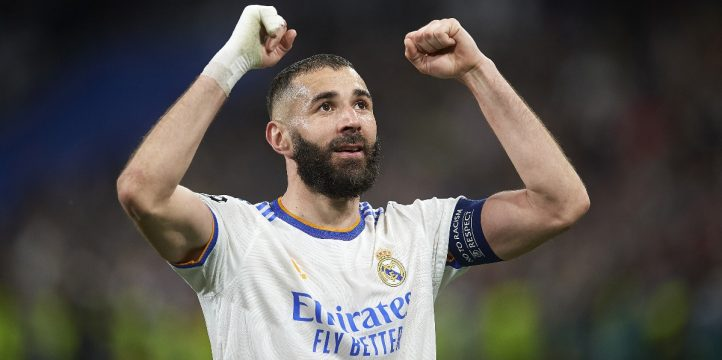

In [7]:
dataset[0]["image"]

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [8]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [9]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Now that we have loaded the processor, let's load the dataset and the dataloader:

In [10]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [11]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 13.02757740020752
Loss: 10.296637535095215
Loss: 10.166296005249023
Epoch: 1
Loss: 10.15517807006836
Loss: 10.156251907348633
Loss: 10.176460266113281
Epoch: 2
Loss: 10.152420997619629
Loss: 10.085200309753418
Loss: 10.085652351379395
Epoch: 3
Loss: 10.099069595336914
Loss: 10.052311897277832
Loss: 10.057852745056152
Epoch: 4
Loss: 10.029461860656738
Loss: 10.039878845214844
Loss: 10.02049446105957
Epoch: 5
Loss: 9.98608112335205
Loss: 9.977014541625977
Loss: 9.939343452453613
Epoch: 6
Loss: 9.883445739746094
Loss: 9.287158012390137
Loss: 9.481474876403809
Epoch: 7
Loss: 8.901866912841797
Loss: 8.65135383605957
Loss: 8.46634292602539
Epoch: 8
Loss: 8.209858894348145
Loss: 7.998665809631348
Loss: 7.690981388092041
Epoch: 9
Loss: 7.491954803466797
Loss: 7.3415207862854
Loss: 7.11062479019165
Epoch: 10
Loss: 6.919283390045166
Loss: 6.755097389221191
Loss: 6.588143348693848
Epoch: 11
Loss: 6.383719444274902
Loss: 6.277321815490723
Loss: 6.086118698120117
Epoch: 12
Loss: 5.93350601196

## Inference

Let's check the results on our train dataset

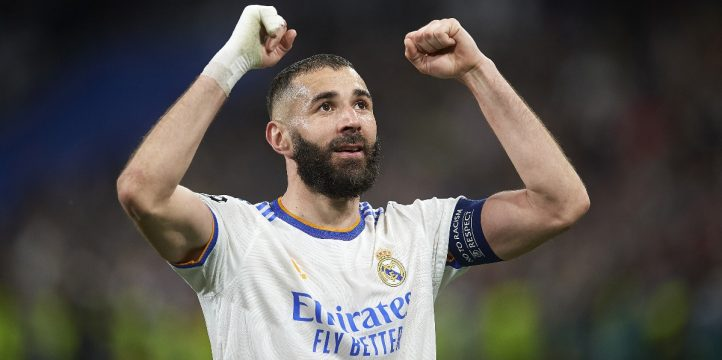

In [12]:
# load image
example = dataset[0]
image = example["image"]
image

In [13]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

benzema after real mardid ' s win against psg


## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later.
Meanwhile you can play with the model that we have fine-tuned!

In [14]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Let's check the results on our train dataset!

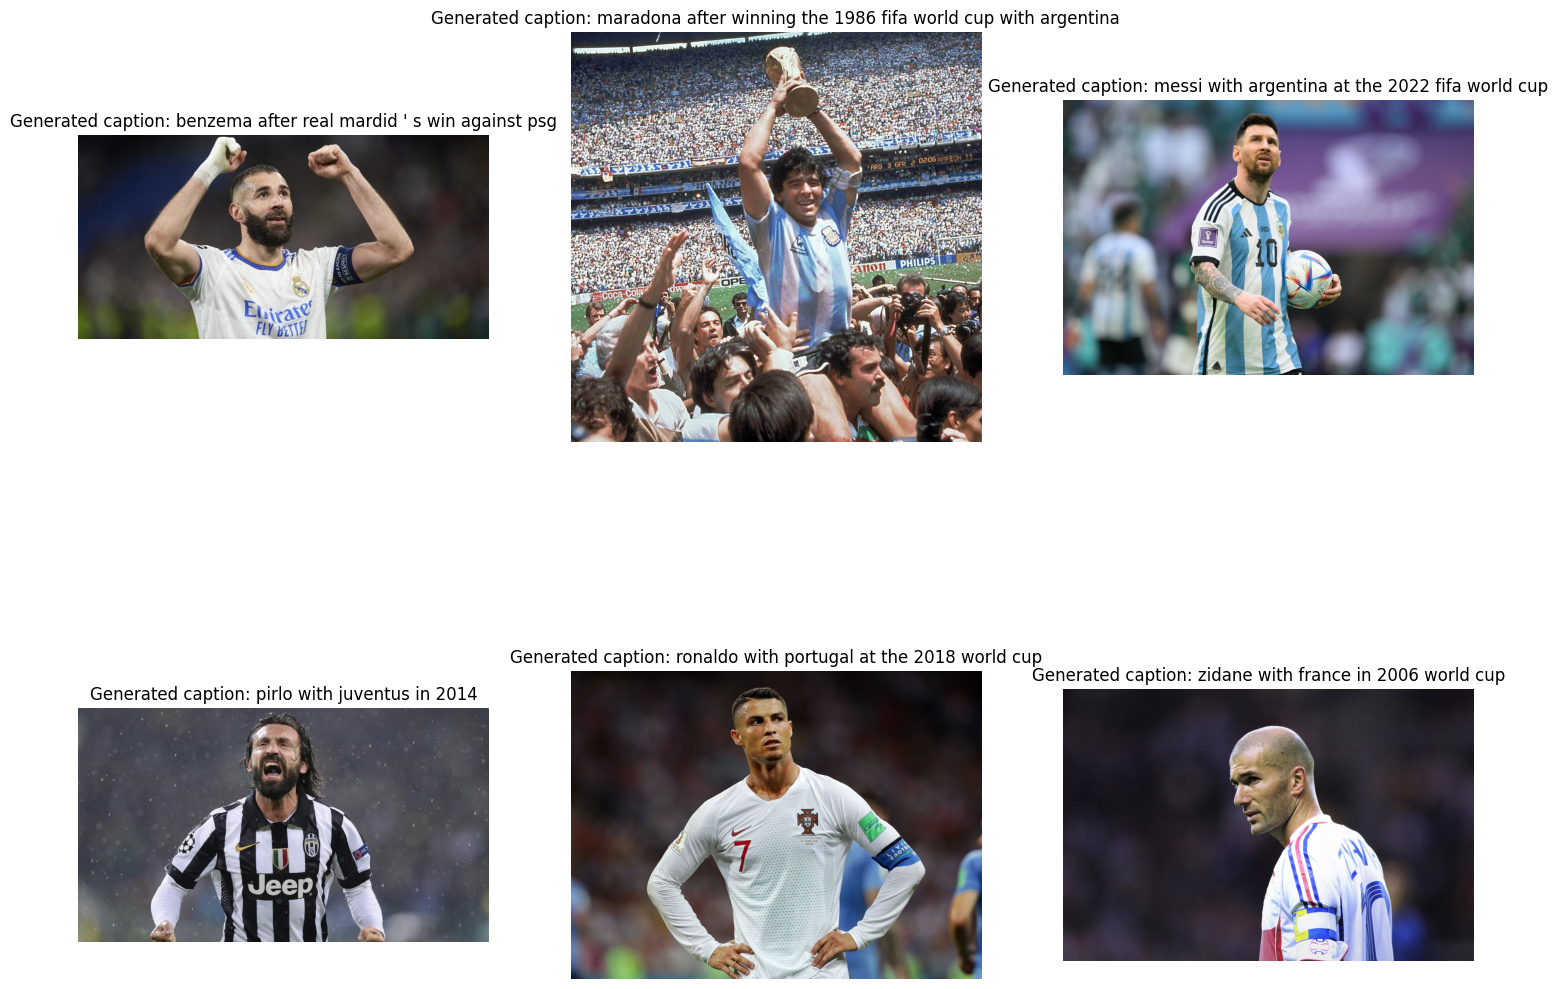

In [15]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")

In [16]:
from PIL import Image
image = Image.open("/prueba.png")

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(f"generated caption {generated_caption}")

generated caption messi with argentina at the 2022 fifa world cup
